In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


pd.set_option('display.max_columns', None)

# 1. Wat voor soort supervised learning gaan we toepassen?

We willen voorspellen wat het resultaat van een wedstrijd is. Het resultaat kan 3 mogelijkheden hebben. 'win', 'loss' en 'draw'. We hebben dus een classificatie probleem hier. Voor dit classificatie probleem hebben we meer dan 2 mogelijkheden dit wordt ook wel 'mulit-class classification' genoemd.

# 2. Voeg het resultaat van iedere wedstrijd toe aan het match dataframe.

We hebben een class gemaakt. We vinden het nog steeds best lastig om in te schatten wat handig is voor deze opdracht. Uiteindelijk hebben we dus hiervoor gekozen. Bij de initialisatie van 'Project' zal er een method gebruikt worden '_make_results' die de resultaten toevoegd. 

We hebben de resultaten als numerieke waarden ingesteld. Zo staat 3 voor een thuisoverwinning, 2 een gelijkspel en 1 voor een verlies van het thuisteam. Dit is op ordinale schaal zodat goed duidelijk is dat 3 het beste resultaat is. Dit hebben we zo gedaan zodat we makkelijk correlaties kunnen checken.

In [2]:
class Project():    
    def __init__(self):
        self.conn = sqlite3.connect('../Downloads/database.sqlite')
        self.match = self._make_query(""" SELECT * FROM match """)
        self.player_attributes = self._make_query(""" SELECT * FROM player_attributes """)
        self.team = self._make_query(""" SELECT * FROM team """)
        self._make_results()
        
    def _make_results(self):
        result = []
        for row in self.match.itertuples():
            if row.home_team_goal > row.away_team_goal: result.append(3)
            elif row.home_team_goal < row.away_team_goal: result.append(1)
            else: result.append(2)
        self.match['result'] = result
        self.match.insert(11, 'result', self.match.pop('result'))
    
    def _make_query(self, query):
        cursor = self.conn.cursor()
        execution = cursor.execute(query)
        result = pd.DataFrame(execution.fetchall(), columns=[i[0] for i in execution.description])
        return result

    def add_attributes(self, season='2014/2015', attribute='overall_rating', inplace=False):
        player_columns = ['home_player_' + str(i) for i in range(1, 12)] + ['away_player_' + str(i) for i in range(1, 12)]
        player_ratings = round(self.player_attributes.groupby('player_api_id')[attribute].mean(), 0)
        
        df = self.match.copy()
        df = df[df['season'] == season]
        
        for column in player_columns:
            rating_column = column + '_rating'
            df[rating_column] = df[column].apply(lambda x: player_ratings[x] if not np.isnan(x) else np.nan)
        
        if inplace:
            self.match = df
            return df
        else:
            return df
        
    def team_ratings(self, df=None, season='2014/2015', attribute='overall_rating'):            
        df = self.match[self.match['season'] == season]
        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
        df = df.select_dtypes(include=numerics)
        
        home_ratings = df.groupby(['home_team_api_id']).mean().iloc[:, -22:-11].mean(axis=1)
        away_ratings = df.groupby('away_team_api_id').mean().iloc[:, -11:].mean(axis=1)
        
        ratings = pd.concat([home_ratings, away_ratings], axis=1).mean(axis=1).reset_index()

        return pd.merge(self.team[['team_api_id', 'team_long_name']], ratings, left_on='team_api_id', right_on='index').drop(['index'], axis=1).rename(columns={0 : attribute})
    
    def features(self, season='2014/2015'):
        result = pd.DataFrame()
        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
        attributes = self.player_attributes.select_dtypes(include=numerics).columns[3:]
        
        for attribute in attributes:
            df_left = self.add_attributes(season=season, attribute=attribute, inplace=True)
            df_right = self.team_ratings(season=season, attribute=attribute)
            
            df_left_ = pd.merge(df_left, df_right, left_on='home_team_api_id', right_on='team_api_id').rename(columns={attribute : attribute + '_home_rating'})
            df_left_ = pd.merge(df_left_, df_right, left_on='away_team_api_id', right_on='team_api_id').rename(columns={attribute : attribute + '_away_rating'})

            result['result'] = df_left_['result']
            result[attribute + '_difference'] = df_left_[attribute + '_home_rating'] - df_left_[attribute + '_away_rating']
        
        return result
            
    def close_connection(self):
        self.conn.close()

    def __del__(self):
        self.conn.close()


In [3]:
Project().match.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,result,home_player_X1,home_player_X2,home_player_X3,home_player_X4,home_player_X5,home_player_X6,home_player_X7,home_player_X8,home_player_X9,home_player_X10,home_player_X11,away_player_X1,away_player_X2,away_player_X3,away_player_X4,away_player_X5,away_player_X6,away_player_X7,away_player_X8,away_player_X9,away_player_X10,away_player_X11,home_player_Y1,home_player_Y2,home_player_Y3,home_player_Y4,home_player_Y5,home_player_Y6,home_player_Y7,home_player_Y8,home_player_Y9,home_player_Y10,home_player_Y11,away_player_Y1,away_player_Y2,away_player_Y3,away_player_Y4,away_player_Y5,away_player_Y6,away_player_Y7,away_player_Y8,away_player_Y9,away_player_Y10,away_player_Y11,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.73,3.40,5.00,1.75,3.35,4.20,1.85,3.2,3.5,1.80,3.3,3.75,NaN,NaN,NaN,1.70,3.30,4.33,1.90,3.3,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.95,3.20,3.60,1.80,3.30,3.95,1.90,3.2,3.5,1.90,3.2,3.50,NaN,NaN,NaN,1.83,3.30,3.60,1.95,3.3,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,2.38,3.30,2.75,2.40,3.30,2.55,2.60,3.1,2.3,2.50,3.2,2.50,NaN,NaN,NaN,2.50,3.25,2.40,2.63,3.3,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.44,3.75,7.50,1.40,4.00,6.80,1.40,3.9,6.0,1.44,3.6,6.50,NaN,NaN,NaN,1.44,3.75,6.00,1.44,4.0,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,5.00,3.50,1.65,5.00,3.50,1.60,4.00,3.3,1.7,4.00,3.4,1.72,NaN,NaN,NaN,4.20,3.40,1.70,4.50,3.5,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


# 3, 4. Keuze voor de ‘features’ en de dataframe.

We hebben in de vorige sprints al bekeken of 'team_attributes' goede correlatie met het aantal punten wat een team zou halen. Dit had echter totaal geen relatie met het aantal punten dat een team haalde. Dit werkte totaal niet goed dus hebben we gekozen om niks van 'team_attributes' te gebruiken. We hebben nu gekozen om alleen de 'player_attributes' te gebruiken. Het kan goed aangeven hoe goed een team was op een bepaald moment. De data is afkomstig uit de videogame FIFA dus het is niet helemaal geweldig maar we gaan kijken hoever we kunnen komen.

Bij de vorige sprint hebben we al kunnen laten zien wat een team zijn gemiddelde 'overall rating' is. We kunnen dit gebruiken om het thuis en uit team te vergelijken met elkaar. We hebben dus gekozen om het verschil tussen het thuis en uit team te gaan maken als feature. We gaan dit niet alleen voor 'overall rating' doen maar voor alle ratings in 'player_attributes'.

In [4]:
seasons = ['2008/2009', '2009/2010', '2010/2011', '2011/2012', '2012/2013', '2013/2014', '2014/2015', '2015/2016']

dataframes = []
for season in seasons:
    dataframes.append(Project().features(season))
    
df = pd.concat(dataframes)

### Normaal verdeeld?

Voordat we gaan bekijken welke features echt goed werken gaan we eerst kijken wat voor soort correlatie methode we moeten gebruiken. We gaan dus kijken of de data goed normaal verdeeld is.


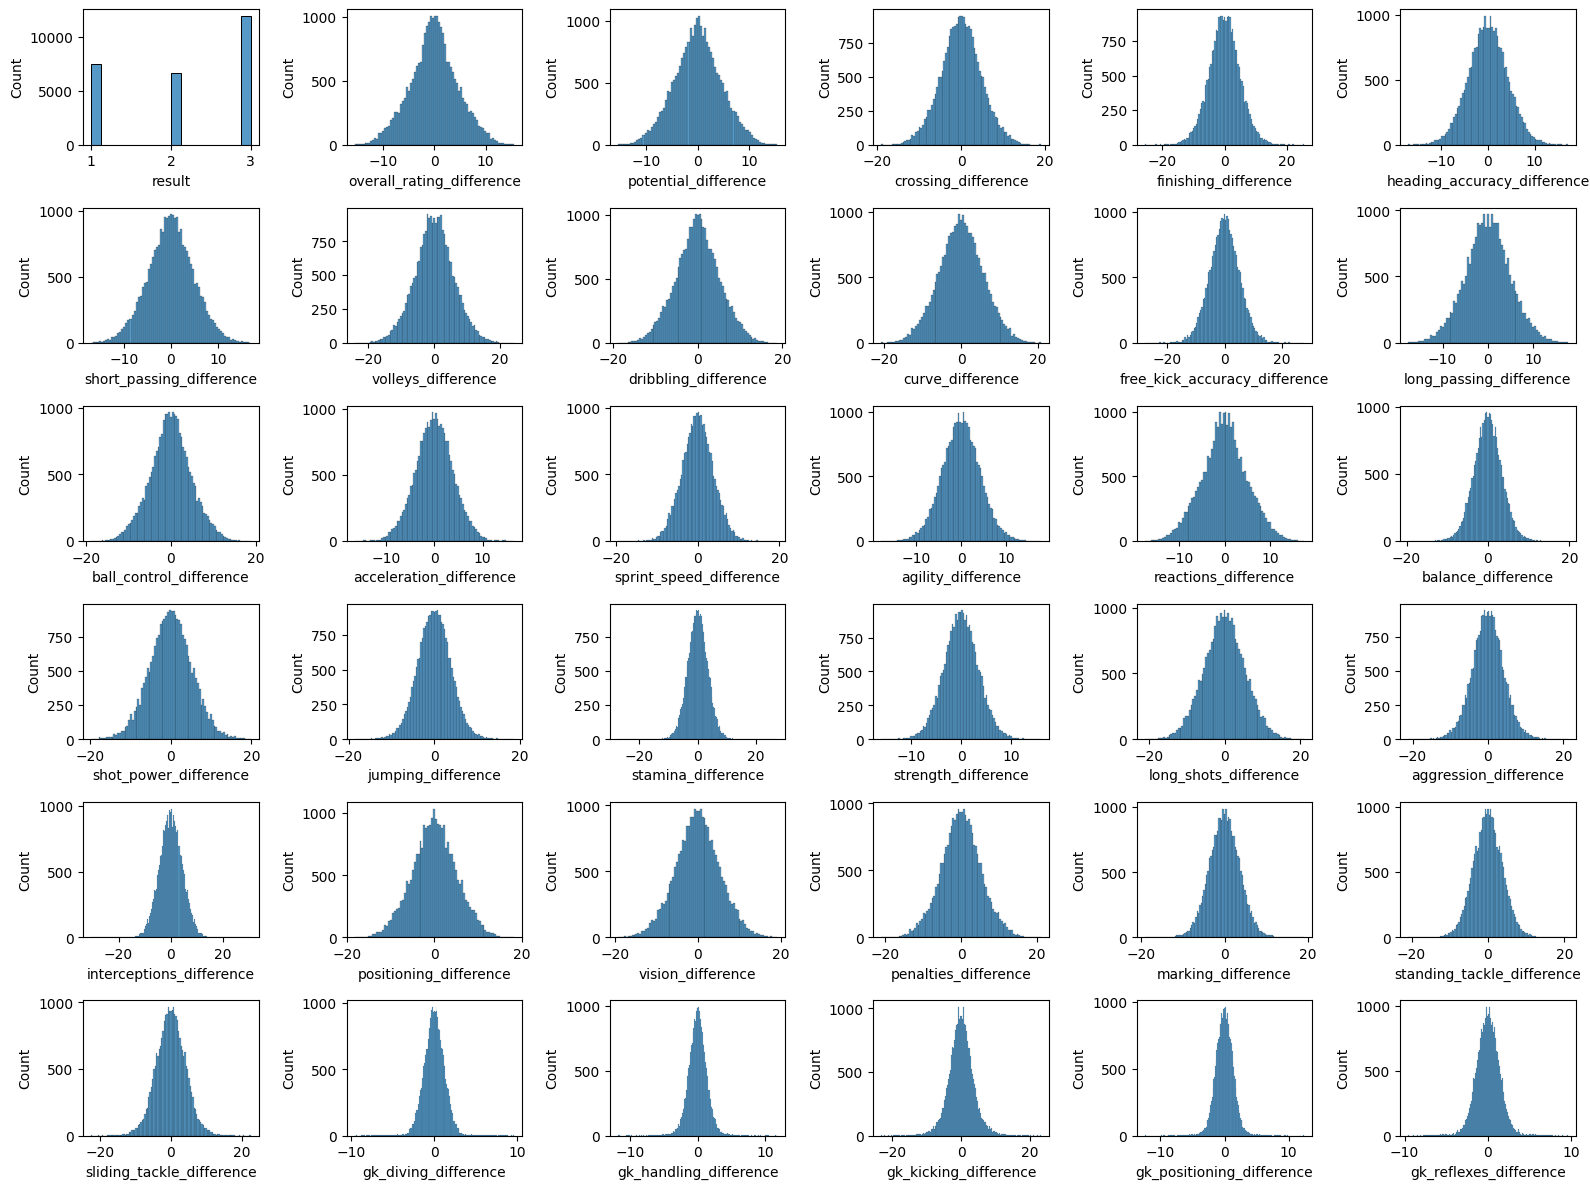

In [5]:
columns = df.columns

fig, axis = plt.subplots(nrows=6, ncols=6, figsize=(16, 12))

for i in range(36):
    sns.histplot(data=df, x=columns[i], ax=axis[i//6][i%6])

fig.tight_layout()

### Welke 'features'?

Het is vrij moeilijk om goede features te kiezen alleen op basis van de correlatie hieronder. Dit komt omdat we een 'multi-class classification' probleem hebben. We gaan daarom alle features gebruiken. Dit zorgt dat het meer computatie kost maar de dataset is vrij klein dus dit is niet echt een probleem. Ook kunnen me met regularisatie goed kijken welke features echt belangrijk zijn. We kiezen dus ook voor de 'Lasso' regularisatie techniek bij het maken van het model.

<Axes: >

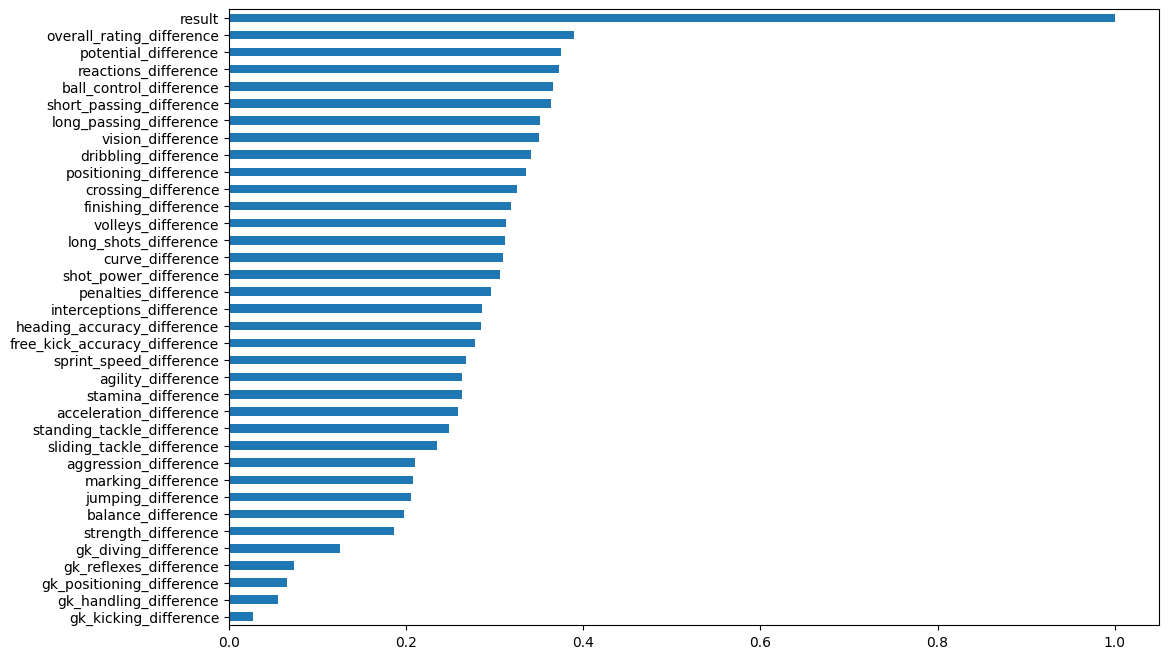

In [6]:
df.corr()['result'].sort_values().plot.barh(figsize=(12, 8))

# 5, 6. Twee algoritmes om de resultaten van de wedstrijden te voorspellen.

We hebben te maken met een 'multi-class classification' probleem dus kiezen we voor modellen die een class voorspellen. We hebben nu de laatste weken 2 verschillende modellen geleerd die dit kunnen namelijk 'KNN' en 'Logistic regression'. We gaan deze dus gebruiken, en we gaan ze ook in combinatie met een gridsearch implementeren. We kunnen hierdoor de beste hyperparameters kiezen voor onze modellen. We splitsen ook de dataframe in 2 stukken namelijk de trainset en testset. We kunnen dus de trainset gebruiken om de gridsearch goed uit te voeren en de testset laten we ongezien zodat we goed kunnen zien dat het model niet overfitted is.

### KNN

In [8]:
X = df.drop('result', axis=1)
y = df['result']
y = y.map({1 : 'loss', 2: 'draw', 3: 'win'})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn = KNeighborsClassifier()
param_grid = {'n_neighbors': range(1, 31), 'weights': ['uniform', 'distance']}

grid_search_knn = GridSearchCV(knn, param_grid, cv=5)
grid_search_knn.fit(X_train, y_train)

y_predictions = grid_search_knn.predict(X_test)

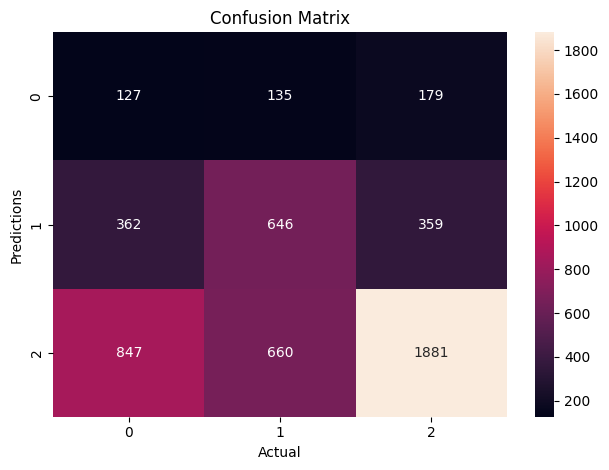

In [9]:
cm = confusion_matrix(y_predictions, y_test)

ax = sns.heatmap(cm, annot=True, fmt="d")
ax.set(xlabel='Actual', ylabel='Predictions')

ax.set_title('Confusion Matrix')

plt.tight_layout()

In [10]:
print(classification_report(y_test, y_predictions))

              precision    recall  f1-score   support

        draw       0.29      0.10      0.14      1336
        loss       0.47      0.45      0.46      1441
         win       0.56      0.78      0.65      2419

    accuracy                           0.51      5196
   macro avg       0.44      0.44      0.42      5196
weighted avg       0.46      0.51      0.47      5196



### Uitslagen
Hierboven zie je de resultaten van het beste model wat gridsearch heeft kunnen vinden. We gaan kort uitleggen wat er allemaal opvalt. De f1-scores worden niet toegelicht omdat de dataset ongebalanceerd is. De dataset bevat namelijk 2 keer zoveel wins t.o.v. zowel loss en draw.

<b>Draw</b><br>
De precisie is vrij laag (0.29) en de recall is zeer laag (0.10). Dit betekent dat wanneer je model een gelijkspel voorspelt het slechts ongeveer 29% van de tijd correct is. Bovendien vangt het model slechts 10% van de daadwerkelijke gelijkspelen correct op.

<b>Loss</b><br>
De precisie en recall zijn (0.47) en (0.45). De precisie wil zeggen dat het model ongeveer 47% van de tijd correct is wanneer het voorspelt dat het thuisteam verliest. De recall vangt 45% van de daadwerkelijke verliezen correct op.

<b>Win</b><br>
De precisie is (0.56) Het is dus 56% van de tijd correct in het voorspellen van een thuisoverwinning. De recall is (0.78) dit betekent dat het model 78% van de daadwerkelijke winstpartijen correct identificeert.

### Logistic Regression

In [11]:
logreg = LogisticRegression(max_iter=3000)

param_grid = {'C': np.linspace(0.0001, 1, 10), 'class_weight': [None, 'balanced']}

grid_search_logreg = GridSearchCV(logreg, param_grid, cv=5)
grid_search_logreg.fit(X_train, y_train)

y_predictions = grid_search_logreg.predict(X_test)

In [12]:
grid_search_logreg.best_params_

{'C': 0.8889, 'class_weight': None}

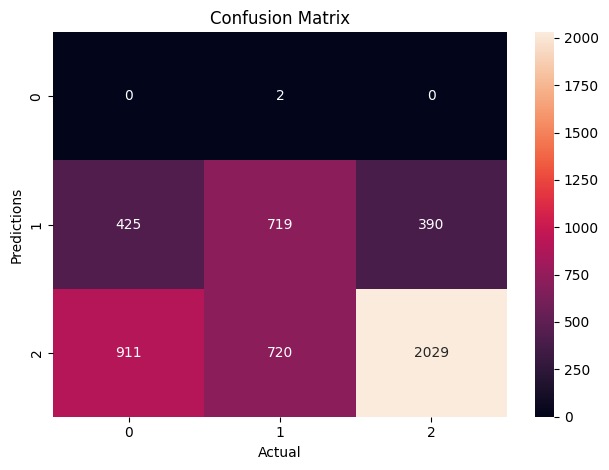

In [13]:
cm = confusion_matrix(y_predictions, y_test)

ax = sns.heatmap(cm, annot=True, fmt="d")
ax.set(xlabel='Actual', ylabel='Predictions')

ax.set_title('Confusion Matrix')

plt.tight_layout()

In [14]:
print(classification_report(y_test, y_predictions))

              precision    recall  f1-score   support

        draw       0.00      0.00      0.00      1336
        loss       0.47      0.50      0.48      1441
         win       0.55      0.84      0.67      2419

    accuracy                           0.53      5196
   macro avg       0.34      0.45      0.38      5196
weighted avg       0.39      0.53      0.44      5196



### Uitslagen
Hierboven zie je de resultaten van het beste model wat gridsearch heeft kunnen vinden. Net zoals eerder gaan we kort uitleggen wat er allemaal opvalt. De f1-scores worden niet toegelicht omdat de dataset ongebalanceerd is. We hebben zelfs een hyperparameter gebruikt die de dataset zou balanceren maar die gaf slechtere uitkomsten dan het beste model. De dataset bevat namelijk 2 keer zoveel wins t.o.v. zowel loss en draw.

<b>Draw</b><br>
Zowel de precisie als de recall voor deze klasse zijn (0.00) Er is geen enkel correct gelijkspel correct voorspelt. Dit betekent dat wanneer het model een gelijkspel voorspelt! Het heeft ook geen enkel gelijkspel geindentificeert want de recall is ook (0.00). Dit is een ernstig probleem en zegt eigenlijk dat het model niet in staat is om gelijkspelen te voorspellen. We weten niet hoe dit komt we gebruiken dezelfde training en test sets.

<b>Loss</b><br>
De prestaties van het model zijn beter voor de klasse 'draw'. De precisie en recall zijn (0.47) en (0.50). Dit betekent dat het model ongeveer 47% van de tijd correct is wanneer het voorspelt dat het thuisteam verliest De recall zegt dat het 50% van de daadwerkelijke verliezen correct identificeert.

<b>Win</b><br>
De precisie is (0.55) wat betekent dat wanneer het model voorspelt dat het thuisteam wint het 55% van de tijd correct is. De recall is zeer hoog (0.84), wat betekent dat het model 84% van de daadwerkelijke winstpartijen correct identificeert.


### Conclusie

Het is vrij moeilijk om dit echt gaan te gebruiken. We hebben best goede modellen als het aankomt op het correct voorspellen van thuisoverwinningen. Dat het laatste model alleen geen gelijkspellen kon voorspellen is wel een ernstig probleem. We zullen dan dus ook kiezen voor het 'KNN' model omdat dit een wat meer gebalanceerdere uitkomst heeft.

Toch is het nog steeds niet echt een goed model. We zouden dit onderzoek eigenlijk nog een keer moeten doen met andere data of toch een andere aanpak? Aan de andere kant geldt voor zowel de 'team_attributes' en 'player_attributes' dat het data is wat afkomstig is uit een videogame. De makers van dat spel hebben de spelers zelf gecatogoriseerd op een schaal van 1-100. Dit kan natuurlijk veel onzekerheid geven ook natuurlijk omdat veel van die data dan ook per jaar misschien steeds op een andere manier is gemaakt. 

Het zou misschien beter zijn om goed na te denken over wat voor soort data we nodig zouden hebben voordat we dit nog een keer uitzoeken. Op dit moment is dit het beste wat we kunnen doen.

# 7. Bezwaren door werken met Persoonsdata?

Er wordt in dit project niet met persoonsdata gewerkt behalve de namen van de spelers. De tabel 'player_attributes' heeft alleen maar gegevens die gecreeerd zijn door de makers van FIFA.  

De AVG zegt niet specifiek iets over gegenereerde data op basis van iemand zijn identiteit. Wetgeving zou dus niet voldoen en daarom zou het verstandig zijn om goed na te denken over de ethische overwegingen.

Wij moeten zorgen dat we de gegevens niet gebruiken voor doeleinden die discriminerend, rascistisch, etc zijn. 
Al moeten we wel zeggen dat het totaal ongeloofwaardig zou zijn. We zouden dan dus bijvoorbeeld zeggen 'Door dat er een bepaalde gegenereerde waarde is bij deze spelers/team in FIFA kunnen we zeggen dat...'. Dit heeft niet echt veel betekenis omdat de data niet echt serieus te nemen is. 

Als advies zouden we wel alle spelersnamen anominiseren. Dit omdat het eigenlijk het enige echte personendata is in de dataset. Je zou als je heel veel FIFA speelt dan wel nog de spelers kunnen identificeren aan de hand van de ratings. De makers van FIFA doen dit overigens zelf niet. Vaak worden de 'player_attributes' pas bekend gemaakt op de release van de game voor zowel de spelers als gebruikers van de game. 